## Conjunto de Datos

### Citación del Conjunto de Datos

Yeh, I. (2018). *Real Estate Valuation* [Dataset]. UCI Machine Learning Repository. [https://doi.org/10.24432/C5J30W](https://doi.org/10.24432/C5J30W)

El conjunto de datos históricos del mercado de valoración de bienes raíces se recopilan del Distrito Sindian, Ciudad Nueva Taipei, Taiwán.

| **Variable Name**                | **Role**   | **Type**      | **Description**                                               | **Units**                          |
|----------------------------------|------------|---------------|---------------------------------------------------------------|-------------------------------------|
| `No`                             | ID         | Integer       | Identification number                                         | None                                |
| `X1 transaction date`            | Feature    | Continuous    | Transaction date (e.g., 2013.250 = 2013 March, 2013.500 = 2013 June) | None                                |
| `X2 house age`                   | Feature    | Continuous    | Age of the house                                              | Years                               |
| `X3 distance to the nearest MRT station` | Feature    | Continuous    | Distance to the nearest Mass Rapid Transit station                           | Meters                              |
| `X4 number of convenience stores` | Feature   | Integer       | Number of convenience stores within walking distance          | Count                               |
| `X5 latitude`                    | Feature    | Continuous    | Geographic latitude coordinate                                | Degrees                             |
| `X6 longitude`                   | Feature    | Continuous    | Geographic longitude coordinate                               | Degrees                             |
| `Y house price of unit area`     | Target     | Continuous    | House price per unit area                                     | 10000 New Taiwan Dollar/Ping (303.07 USD/3.3 Squared Meters)       |


## Descripción del problema

Ser capaces de predecir los precios de los bienes inmobiliarios es de altisima importancia para multiples intereses, sean compradores, vendedores o inversores. La capacidad de predecir con exactitud los precios beneficia a la estabilidad económica, la planificación financiera individual y el desarrollo estratégico en entornos urbanos, por ello se entrena un modelo de machine learning usando el dataset Real Estate Valuation citado anteriormente (real-state-valuation.xlsx) para ser capaces de predecir el precio de un bien inmueble (el precio por unidad de área) usando los parametros que se pueden observar en la tabla de arriba. En problemas de regresión como estos se puede definir la función de perdida usando minimos cuadrados, a continuación veremos una implementación de dicho modelo usando el dataset ya mencionado

## Implementación

In [10]:
# Importar las librearias necesarias
import pandas as pd
import numpy as np
import tensorflow as tf
import random as rn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from itertools import product

# Carga del conjunto de datos desde un archivo Excel.
market_data = pd.read_excel(r'real-estate-valuation.xlsx')

# Visualización de información básica sobre el conjunto de datos
print(market_data.info())
print(market_data.head())
print(market_data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 8 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   No                                      414 non-null    int64  
 1   X1 transaction date                     414 non-null    float64
 2   X2 house age                            414 non-null    float64
 3   X3 distance to the nearest MRT station  414 non-null    float64
 4   X4 number of convenience stores         414 non-null    int64  
 5   X5 latitude                             414 non-null    float64
 6   X6 longitude                            414 non-null    float64
 7   Y house price of unit area              414 non-null    float64
dtypes: float64(6), int64(2)
memory usage: 26.0 KB
None
   No  X1 transaction date  X2 house age  \
0   1          2012.916667          32.0   
1   2          2012.916667          19.5   
2   3          201

In [11]:
# Renombrar las columnas del conjunto de datos para facilitar su uso.
market_data = market_data.rename(columns={'X1 transaction date': 'transaction date',                 
                                          'X2 house age': 'house age',                            
                                          'X3 distance to the nearest MRT station': 'distance to the nearest MRT station',
                                          'X4 number of convenience stores': 'number of convenience stores',
                                          'X5 latitude': 'latitude',                
                                          'X6 longitude': 'longitude',                 
                                          'Y house price of unit area': 'house price of unit area'})

In [12]:
# Configuración de la semilla para reproducibilidad.
seed = 1
tf.random.set_seed(seed)
rn.seed(seed)
np.random.seed(seed)
tf.config.experimental.enable_op_determinism()

# Preparación de los datos: separación en características (X) y variable objetivo (y).
X = market_data.drop(['No'], axis=1)
y = market_data['house price of unit area']

# Dividimos los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [13]:
neurons_list = [20, 30, 40, 50, 60] # Número de neuronas en las capas ocultas.
learning_rate_list = [0.001, 0.01, 0.1] # Tasa de aprendizaje.
batch_size_list = [16, 32, 64] # Tamaño del lote.
epochs_list = [25, 50, 75, 100] # Número de épocas.

# Generación de todas las combinaciones posibles de hiperparámetros.
param_grid = list(product(neurons_list, learning_rate_list, batch_size_list, epochs_list))

best_params = None
best_loss = np.inf

# Búsqueda de los mejores hiperparámetros.
for neurons, learning_rate, batch_size, epochs in param_grid:
    # Definición de la arquitectura de la red neuronal.
    neural_network = tf.keras.Sequential([
        # Capa de entrada con forma igual a las características.
        tf.keras.Input(shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(neurons, activation='relu', kernel_initializer=tf.keras.initializers.HeNormal(seed=seed)), # Capa oculta.
        tf.keras.layers.Dense(neurons, activation='relu', kernel_initializer=tf.keras.initializers.HeNormal(seed=seed)), # Otra capa oculta.
        tf.keras.layers.Dense(1, kernel_initializer=tf.keras.initializers.HeNormal(seed=seed)) # Capa de salida.
    ])

    # Compilación del modelo con función de pérdida y optimizador.
    neural_network.compile(
        loss='mean_squared_error',
        optimizer=tf.keras.optimizers.Adam(learning_rate)
    )

    # Entrenamiento del modelo.
    neural_network.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=0)

    # Evaluación del modelo en el conjunto de prueba.
    val_loss = neural_network.evaluate(X_test, y_test, verbose=0)

    # Actualización de los mejores parámetros si la pérdida actual es menor.
    if val_loss < best_loss:
        best_loss = val_loss
        best_params = (neurons, learning_rate, batch_size, epochs)

# Impresión de los mejores parámetros.
print(f"Best Parameters: Neurons={best_params[0]}, Learning Rate={best_params[1]}, Batch Size={best_params[2]}, Epochs={best_params[3]}")
print(f"Best Validation Loss: {best_loss}")

Best Parameters: Neurons=20, Learning Rate=0.1, Batch Size=16, Epochs=75
Best Validation Loss: 0.27947139739990234


In [21]:
# Entrenamos un modelo final con los mejores parámetros encontrados
neural_network = tf.keras.Sequential([
    tf.keras.Input(shape=(X_test.shape[1],)),
    tf.keras.layers.Dense(20, activation='relu', kernel_initializer=tf.keras.initializers.HeNormal(seed=seed)),
    tf.keras.layers.Dense(20, activation='relu', kernel_initializer=tf.keras.initializers.HeNormal(seed=seed)),
    tf.keras.layers.Dense(1, kernel_initializer=tf.keras.initializers.HeNormal(seed=seed))
])

neural_network.compile(
    loss='mean_squared_error',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1)
)

# Entrenamos el modelo final y almacenamos su historial
history = neural_network.fit(X_train, y_train, batch_size=16, epochs=75, verbose=0)

# Evaluamos el modelo final en el conjunto de prueba
neural_network.evaluate(X_test, y_test, verbose=0)

0.27947139739990234

In [22]:
neural_network.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                      │ (None, 20)                  │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 20)                  │             420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,805 (7.05 KB)

 Trainable params: 601 (2.35 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,204 (4.71 KB)

## Visualización

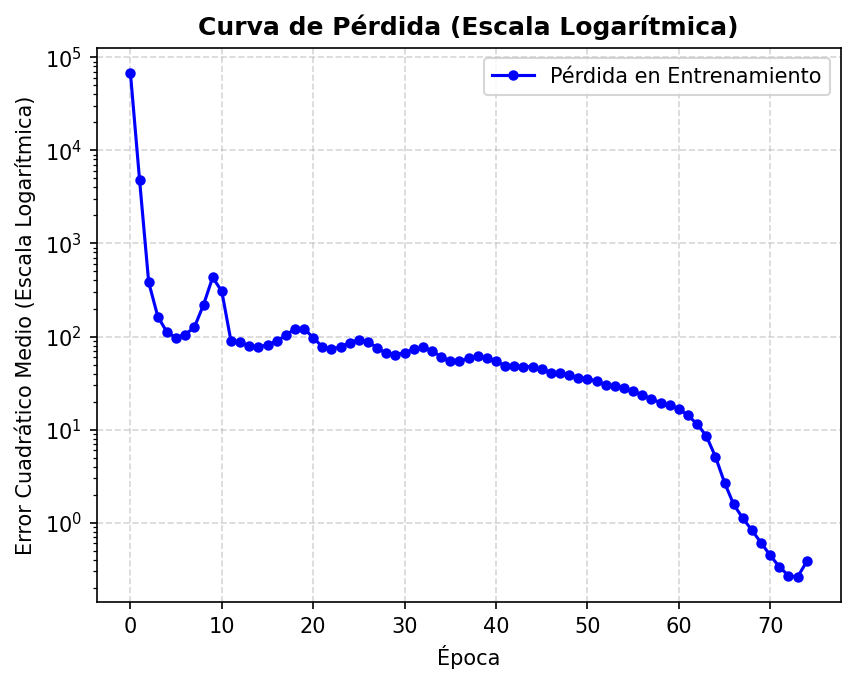

In [29]:
# Configuración para mejorar la calidad de las visualizaciones
plt.rcParams['figure.dpi'] = 150 

# Gráfico de la curva de pérdida durante el entrenamiento
plt.plot(history.history['loss'], label='Pérdida en Entrenamiento', c='b', marker='o', markersize=4)
plt.title('Curva de Pérdida (Escala Logarítmica)', fontweight='bold')
plt.yscale('log')
plt.xlabel('Época')
plt.ylabel('Error Cuadrático Medio (Escala Logarítmica)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()

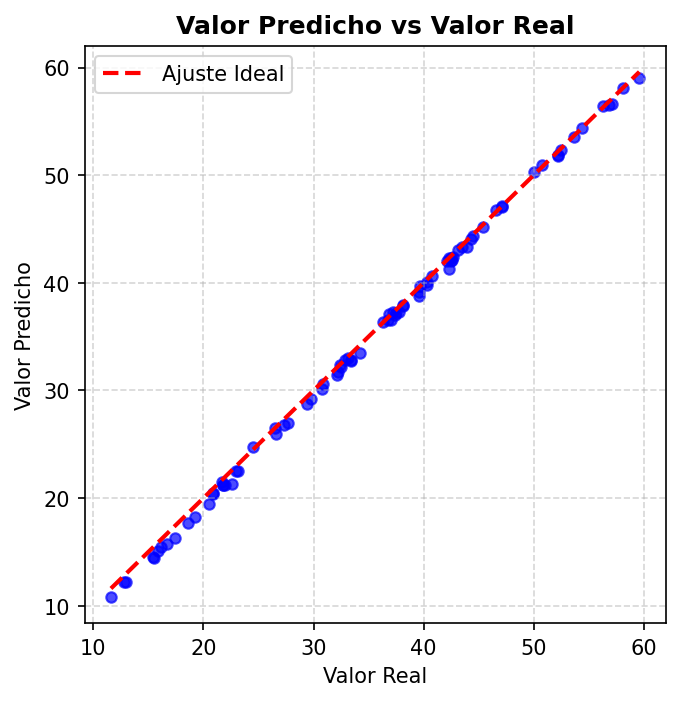

In [31]:
# Realización de predicciones con el modelo entrenado
y_pred = neural_network.predict(X_test, verbose=0)

# Gráfico de dispersión entre los valores reales y las predicciones
plt.figure(figsize=(5, 5))
plt.scatter(y_test, y_pred, s=25, c='b', alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], c='r', linestyle='--', linewidth=2, label='Ajuste Ideal')
plt.grid(True, linestyle='--', alpha=0.5) 
plt.xlabel('Valor Real')
plt.ylabel('Valor Predicho')
plt.title('Valor Predicho vs Valor Real', fontweight='bold')
plt.legend()
plt.show()

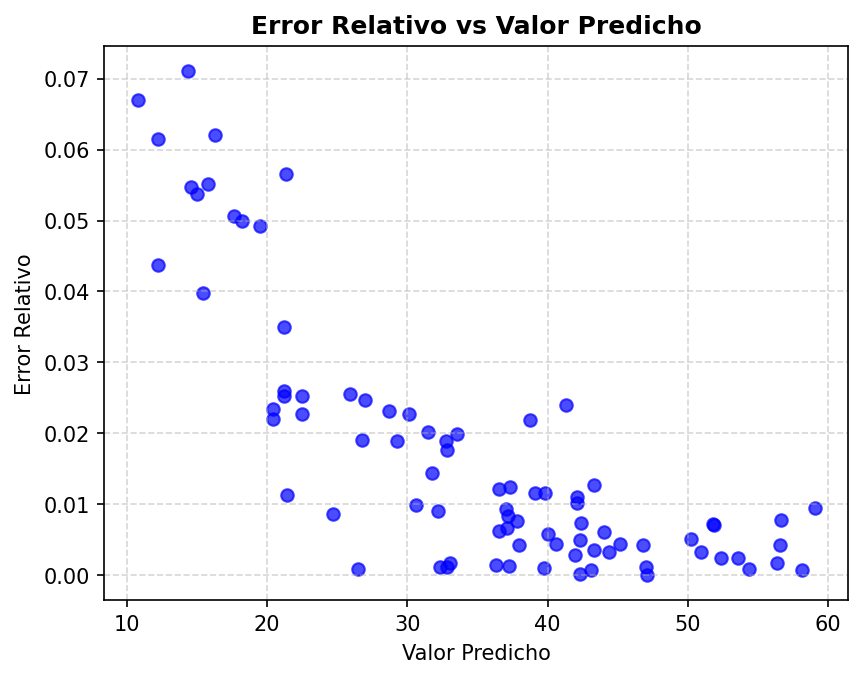

In [28]:
# Calcular error relativo para cada predicción
relative_errors = abs(y_pred[:, 0] - y_test) / abs(y_test)

# Gráfico de dispersión entre los valores reales y los residuales
plt.scatter(y_pred[:, 0], relative_errors, c='b', alpha=0.7)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xlabel('Valor Predicho')
plt.ylabel('Error Relativo')
plt.title('Error Relativo vs Valor Predicho', fontweight='bold')
plt.show()

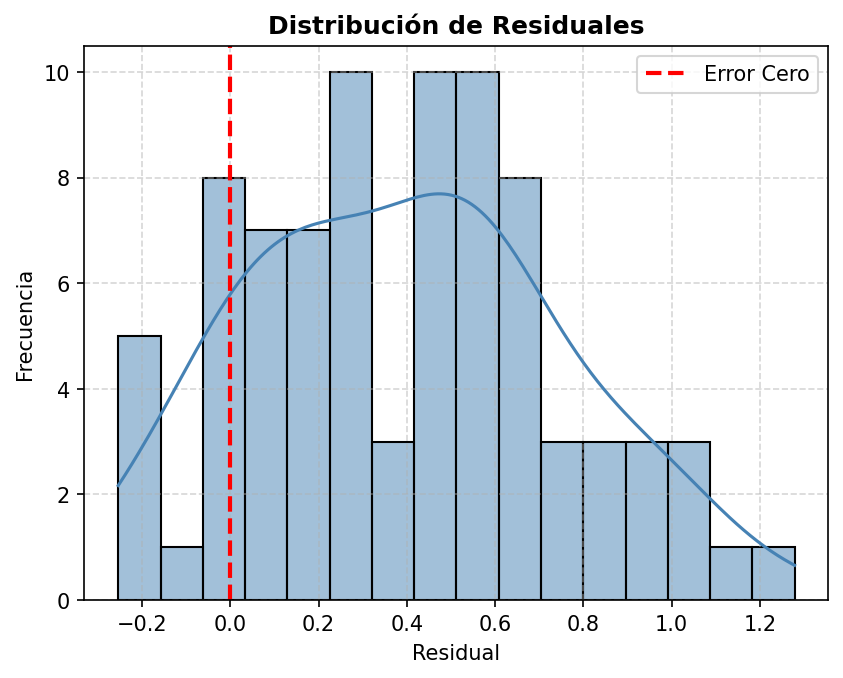

In [33]:
# Cálculo de los residuales (diferencia entre valores reales y predicciones)
residuals = y_test - y_pred[:, 0]

# Histograma de la distribución de los residuales con una curva de densidad
sns.histplot(residuals, bins=16, kde=True, color='steelblue')
plt.axvline(x=0, c='r', linestyle='--', linewidth=2, label='Error Cero')
plt.grid(True, linestyle='--', alpha=0.5)
plt.xlabel('Residual')
plt.ylabel('Frecuencia')
plt.title('Distribución de Residuales', fontweight='bold')
plt.legend()
plt.show()